## Understanding and Defining Churn:
1. Definitions of Churn: This project is based on the Indian and Southeast Asian market. i.e. Prepaid plan
2. Usage-based churn: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time. In this project, you will use the usage-based definition to define churn.
3. High-value Churn: In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage. In this project, you will define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.

## Understanding the Data:
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 

## Understanding the Business Objective:
The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [52]:
np.random.seed(0)

In [53]:
data_dict=pd.read_excel('Data+Dictionary-+Telecom+Churn+Case+Study.xlsx')

data_dict.head()

,Acronyms,Descriptions
0,MOBILE_NUMBER,Customer phone number
1,CIRCLE_ID,Telecom circle area to which the customer belo...
2,LOC,Local calls - within same telecom circle
3,STD,STD calls - outside the calling circle
4,IC,Incoming calls


### Step 1: Importing Data

In [54]:
df=pd.read_csv(r'telecom_churn_data.csv',encoding='ISO-8859-1')
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [55]:
df.isnull().sum()

mobile_number               0
circle_id                   0
loc_og_t2o_mou           1018
std_og_t2o_mou           1018
loc_ic_t2o_mou           1018
last_date_of_month_6        0
last_date_of_month_7      601
last_date_of_month_8     1100
last_date_of_month_9     1659
arpu_6                      0
arpu_7                      0
arpu_8                      0
arpu_9                      0
onnet_mou_6              3937
onnet_mou_7              3859
onnet_mou_8              5378
onnet_mou_9              7745
offnet_mou_6             3937
offnet_mou_7             3859
offnet_mou_8             5378
offnet_mou_9             7745
roam_ic_mou_6            3937
roam_ic_mou_7            3859
roam_ic_mou_8            5378
roam_ic_mou_9            7745
roam_og_mou_6            3937
roam_og_mou_7            3859
roam_og_mou_8            5378
roam_og_mou_9            7745
loc_og_t2t_mou_6         3937
                        ...  
arpu_2g_9               74077
night_pck_user_6        74846
night_pck_

In [56]:
round(100*df.isnull().sum()/len(df.index), 2)

mobile_number            0.00
circle_id                0.00
loc_og_t2o_mou           1.02
std_og_t2o_mou           1.02
loc_ic_t2o_mou           1.02
last_date_of_month_6     0.00
last_date_of_month_7     0.60
last_date_of_month_8     1.10
last_date_of_month_9     1.66
arpu_6                   0.00
arpu_7                   0.00
arpu_8                   0.00
arpu_9                   0.00
onnet_mou_6              3.94
onnet_mou_7              3.86
onnet_mou_8              5.38
onnet_mou_9              7.75
offnet_mou_6             3.94
offnet_mou_7             3.86
offnet_mou_8             5.38
offnet_mou_9             7.75
roam_ic_mou_6            3.94
roam_ic_mou_7            3.86
roam_ic_mou_8            5.38
roam_ic_mou_9            7.75
roam_og_mou_6            3.94
roam_og_mou_7            3.86
roam_og_mou_8            5.38
roam_og_mou_9            7.75
loc_og_t2t_mou_6         3.94
                        ...  
arpu_2g_9               74.08
night_pck_user_6        74.85
night_pck_

In [57]:
for col in df:
    print (df[col].astype('category').value_counts())

7002410905    1
7000807788    1
7000807366    1
7000807373    1
7000807378    1
7000807385    1
7000807411    1
7000807416    1
7000807418    1
7000807423    1
7000807451    1
7000807453    1
7000807468    1
7000807514    1
7000807550    1
7000807578    1
7000807608    1
7000807616    1
7000807644    1
7000807670    1
7000807732    1
7000807744    1
7000807747    1
7000807356    1
7000807290    1
7000807200    1
7000806875    1
7000806519    1
7000806531    1
7000806534    1
             ..
7001610068    1
7001610105    1
7001610162    1
7001610182    1
7001610235    1
7001609661    1
7001609614    1
7001609214    1
7001609405    1
7001609243    1
7001609264    1
7001609270    1
7001609273    1
7001609286    1
7001609334    1
7001609363    1
7001609369    1
7001609370    1
7001609445    1
7001609596    1
7001609459    1
7001609483    1
7001609515    1
7001609517    1
7001609525    1
7001609545    1
7001609553    1
7001609562    1
7001609584    1
7000000074    1
Name: mobile_number, Len

0.00      10827
1.01         86
0.38         75
0.41         73
0.36         71
0.53         69
0.26         69
0.01         64
0.61         63
0.51         63
0.48         63
0.23         63
0.03         62
0.40         62
0.68         60
0.28         60
0.43         59
1.06         59
0.46         59
0.76         59
0.20         58
0.21         58
0.16         58
0.33         58
0.35         58
0.81         57
0.73         57
0.31         57
0.63         57
0.45         56
          ...  
377.61        1
377.71        1
377.73        1
377.74        1
377.83        1
377.88        1
378.01        1
378.08        1
378.11        1
377.14        1
377.11        1
377.08        1
376.79        1
376.33        1
376.49        1
376.51        1
376.58        1
376.66        1
376.73        1
376.74        1
376.83        1
377.06        1
376.84        1
376.89        1
376.94        1
376.96        1
376.98        1
377.01        1
377.04        1
220.86        1
Name: onnet_mou_9, Lengt

Name: roam_og_mou_7, Length: 6639, dtype: int64
0.00      80273
0.03         33
0.43         28
0.23         28
0.18         27
0.55         27
0.01         25
0.51         25
1.01         25
0.50         24
0.31         24
0.60         24
0.16         24
0.26         23
0.38         23
0.13         23
1.21         23
0.78         22
0.53         22
0.40         21
0.20         21
0.81         21
0.56         21
0.30         21
1.03         21
0.08         21
1.18         21
0.76         21
0.71         20
0.85         20
          ...  
105.53        1
105.69        1
106.03        1
106.06        1
106.21        1
106.26        1
104.68        1
104.58        1
102.84        1
104.46        1
102.88        1
102.98        1
103.01        1
103.08        1
103.13        1
103.26        1
103.31        1
103.41        1
103.44        1
103.53        1
103.58        1
103.59        1
103.71        1
103.81        1
104.14        1
104.16        1
104.19        1
104.29        1
104.36  

0.00     55984
0.38       221
0.46       214
0.33       211
0.36       211
0.43       201
0.28       200
0.41       199
0.25       198
0.26       194
0.48       193
0.31       191
0.30       184
0.35       180
0.51       178
0.66       177
0.68       177
0.21       177
0.50       175
0.61       175
0.40       169
0.13       169
0.56       165
0.60       161
0.45       160
0.53       160
0.20       160
0.23       160
0.73       157
0.63       155
         ...  
46.19        1
46.13        1
46.06        1
46.04        1
45.96        1
45.93        1
45.91        1
45.83        1
46.69        1
46.84        1
46.89        1
46.96        1
47.74        1
47.69        1
47.68        1
47.59        1
47.54        1
47.46        1
47.44        1
47.43        1
47.41        1
47.39        1
47.36        1
47.34        1
47.33        1
47.31        1
47.26        1
47.24        1
47.21        1
27.96        1
Name: loc_og_t2f_mou_7, Length: 3863, dtype: int64
0.00      55595
0.38        204
0.

0.00      52259
0.43         71
0.01         61
0.48         61
0.25         61
0.23         60
0.21         57
0.63         57
0.60         57
0.30         55
0.38         54
0.46         54
0.45         53
0.35         52
0.33         52
0.53         52
0.28         52
0.50         51
0.41         51
0.51         50
0.98         50
0.20         50
0.58         50
1.06         50
0.31         49
0.56         49
0.36         48
0.26         47
0.40         46
0.96         46
          ...  
346.49        1
346.44        1
346.36        1
346.33        1
346.31        1
346.26        1
346.14        1
345.93        1
345.88        1
345.73        1
345.66        1
345.46        1
345.31        1
345.28        1
345.26        1
345.19        1
345.16        1
345.04        1
345.01        1
344.89        1
344.78        1
344.74        1
344.39        1
344.33        1
344.31        1
344.28        1
344.14        1
344.11        1
343.89        1
194.08        1
Name: std_og_t2t_mou_6, 

0.00     84451
0.38        67
0.53        67
0.36        63
0.26        63
0.41        63
0.40        63
0.61        62
0.48        61
0.31        60
0.51        59
0.23        59
0.50        57
0.35        57
0.43        57
0.18        56
0.60        56
0.55        55
0.46        54
0.28        53
0.70        52
0.33        52
0.45        51
0.65        51
0.81        51
0.58        51
0.16        49
0.63        49
0.21        48
0.66        47
         ...  
27.56        1
26.94        1
27.03        1
27.04        1
27.09        1
27.13        1
27.20        1
27.21        1
27.23        1
27.26        1
27.33        1
27.45        1
27.54        1
27.55        1
27.64        1
28.66        1
27.68        1
27.84        1
27.93        1
27.94        1
28.06        1
28.14        1
28.24        1
28.28        1
28.38        1
28.46        1
28.51        1
28.54        1
28.63        1
16.98        1
Name: std_og_t2f_mou_6, Length: 2450, dtype: int64
0.00      85213
0.21         60
0.

0.00       48069
0.01         364
0.03         276
0.08         274
0.06         264
0.05         245
0.16         243
0.68         214
0.13         214
0.10         209
0.63         206
0.40         202
0.18         202
0.61         177
0.70         175
0.11         175
0.36         174
0.26         171
0.21         168
0.38         168
0.71         165
0.20         165
0.23         164
0.41         164
0.28         161
0.43         159
0.25         159
0.15         157
0.65         155
0.76         153
           ...  
49.04          1
49.03          1
49.01          1
48.96          1
49.76          1
49.78          1
49.79          1
49.83          1
50.69          1
50.59          1
14.40          1
50.58          1
50.54          1
50.53          1
50.51          1
50.49          1
50.34          1
50.31          1
14.50          1
50.26          1
50.16          1
50.06          1
50.04          1
14.60          1
49.98          1
49.96          1
49.94          1
49.93         

0.00      14143
0.21         81
0.20         49
0.43         35
1.01         33
0.25         32
0.01         32
0.15         29
0.26         28
0.03         26
0.40         25
0.61         25
0.41         24
0.68         24
0.16         24
0.05         24
0.46         23
2.33         23
0.63         23
0.11         23
0.66         22
0.35         21
0.56         20
0.36         20
0.83         19
0.38         19
1.13         19
1.26         19
0.31         19
0.48         19
          ...  
590.24        1
590.26        1
590.28        1
590.34        1
590.39        1
590.41        1
590.51        1
590.54        1
590.59        1
590.63        1
590.64        1
590.71        1
590.73        1
590.78        1
590.84        1
590.86        1
590.91        1
590.94        1
590.96        1
591.01        1
591.11        1
591.19        1
591.21        1
591.23        1
591.36        1
591.54        1
591.58        1
591.59        1
591.64        1
372.29        1
Name: total_og_mou_9, Le

0.00      5339
0.38        40
0.56        37
0.36        37
0.21        36
0.53        36
0.51        35
0.28        34
0.46        33
2.23        33
0.26        33
0.66        33
0.23        32
4.41        32
0.41        31
1.68        31
2.51        31
1.01        31
1.21        31
1.98        30
0.63        29
1.58        28
0.68        28
0.78        28
3.36        28
3.08        28
2.91        28
0.71        28
0.93        28
0.33        28
          ... 
284.19       1
284.21       1
285.26       1
285.24       1
285.13       1
285.11       1
285.06       1
284.96       1
284.93       1
284.91       1
284.89       1
284.88       1
284.86       1
284.83       1
284.79       1
284.78       1
284.74       1
284.71       1
284.63       1
284.61       1
284.59       1
284.53       1
284.49       1
284.44       1
284.39       1
284.38       1
284.31       1
284.28       1
284.23       1
179.94       1
Name: loc_ic_t2m_mou_9, Length: 21484, dtype: int64
0.00     39141
0.23       229
0.2

Name: loc_ic_mou_9, Length: 27697, dtype: int64
0.00     54957
0.03       310
0.01       203
0.05       181
0.21       161
0.26       154
0.43       150
0.18       147
0.46       147
0.33       147
0.23       143
0.31       140
0.30       139
0.28       138
0.20       136
0.06       135
0.25       135
0.41       131
0.16       130
0.15       129
0.48       123
0.51       123
0.63       120
0.36       119
0.38       118
0.35       117
0.68       117
0.58       116
0.13       113
0.08       111
         ...  
81.93        1
81.36        1
81.94        1
81.96        1
81.98        1
81.99        1
82.00        1
82.04        1
82.08        1
81.39        1
81.34        1
80.36        1
80.84        1
80.41        1
80.48        1
80.49        1
80.63        1
80.76        1
80.79        1
80.81        1
80.91        1
81.33        1
80.94        1
81.04        1
81.08        1
81.13        1
81.21        1
81.23        1
81.29        1
46.66        1
Name: std_ic_t2t_mou_6, Length: 6279,

0.00     70927
0.31       184
0.25       158
0.21       157
0.26       156
0.33       149
0.23       141
0.36       140
0.30       139
0.41       138
0.38       135
0.51       127
0.43       127
0.28       123
0.10       122
0.16       119
0.46       119
0.35       118
0.56       118
0.20       111
0.45       111
0.40       111
0.48       109
0.13       107
0.53       106
0.58       103
0.18       103
0.50       102
0.11       102
0.73       100
         ...  
36.39        1
36.29        1
36.14        1
36.11        1
36.08        1
36.06        1
35.93        1
35.76        1
35.69        1
36.69        1
36.73        1
36.88        1
37.39        1
37.71        1
37.60        1
37.58        1
37.56        1
37.49        1
37.46        1
37.44        1
37.33        1
36.91        1
37.21        1
37.20        1
37.18        1
37.16        1
37.13        1
37.01        1
36.98        1
21.59        1
Name: std_ic_t2f_mou_9, Length: 3090, dtype: int64
0.0    96062
Name: std_ic_t2o_mou_

0.00     76854
0.01       297
0.46       134
0.03       121
0.05       106
0.20        87
0.48        85
0.45        81
0.43        79
0.31        67
0.06        66
0.28        64
0.33        55
0.26        54
0.50        51
0.36        51
0.08        47
0.41        46
0.53        46
0.30        46
0.21        45
0.40        44
0.38        43
0.15        41
0.16        40
0.23        40
0.35        40
0.93        38
0.25        37
0.58        37
         ...  
82.26        1
82.48        1
80.83        1
82.58        1
82.61        1
82.63        1
82.73        1
82.76        1
82.84        1
82.86        1
82.03        1
81.98        1
81.94        1
81.86        1
81.00        1
81.03        1
81.04        1
81.16        1
81.21        1
81.34        1
81.38        1
81.44        1
81.54        1
81.55        1
81.59        1
81.64        1
81.76        1
81.78        1
81.81        1
45.34        1
Name: isd_ic_mou_9, Length: 5557, dtype: int64
0.00     73919
0.06       798
0.48    

110     21030
0       11195
50       9555
30       9322
120      5891
154      3944
128      3019
20       2619
90       2500
250      2486
252      2473
200      1920
36       1747
10       1344
44       1239
25       1167
198      1146
100      1090
67       1021
150       949
145       768
98        744
60        688
152       682
350       553
41        498
550       493
65        465
71        427
500       370
        ...  
93          2
405         2
78          2
498         2
547         2
69          2
2010        2
3100        1
3010        1
3150        1
3299        1
2933        1
3350        1
3559        1
34          1
1479        1
825         1
156         1
63          1
650         1
600         1
530         1
460         1
82          1
360         1
334         1
108         1
197         1
180         1
4010        1
Name: max_rech_amt_6, Length: 202, dtype: int64
110     17469
0       11792
50      10699
30       9565
128      4712
120      4500
154      3942


8/31/2014    1998
8/30/2014    1867
8/29/2014    1605
8/28/2014    1275
8/27/2014    1201
8/25/2014    1162
8/26/2014    1129
8/24/2014     977
8/23/2014     921
8/19/2014     863
8/21/2014     766
8/16/2014     760
8/15/2014     754
8/20/2014     746
8/14/2014     743
8/11/2014     743
8/22/2014     737
8/18/2014     716
8/9/2014      697
8/10/2014     690
8/17/2014     663
8/13/2014     662
8/8/2014      643
8/12/2014     607
8/6/2014      601
8/7/2014      569
8/4/2014      544
8/5/2014      533
8/3/2014      431
8/2/2014      412
8/1/2014      324
Name: date_of_last_rech_data_8, dtype: int64
9/29/2014    2329
9/27/2014    1810
9/30/2014    1425
9/26/2014    1315
9/28/2014    1280
9/25/2014    1213
9/23/2014    1113
9/24/2014    1106
9/22/2014     947
9/21/2014     860
9/20/2014     834
9/18/2014     803
9/15/2014     778
9/16/2014     766
9/19/2014     763
9/13/2014     730
9/17/2014     727
9/9/2014      681
9/12/2014     658
9/6/2014      649
9/14/2014     643
9/10/2014     611
9

252.0    2105
175.0    1948
25.0     1339
154.0    1133
23.0     1053
198.0     952
17.0      776
145.0     678
69.0      621
46.0      618
304.0     582
92.0      561
98.0      528
504.0     523
50.0      505
179.0     502
274.0     307
164.0     295
196.0     293
75.0      265
115.0     263
34.0      242
100.0     240
125.0     230
91.0      220
41.0      201
200.0     162
350.0     150
329.0     143
455.0     137
         ... 
576.0       1
577.0       1
582.0       1
584.0       1
588.0       1
591.0       1
593.0       1
605.5       1
606.0       1
607.0       1
612.0       1
613.0       1
614.0       1
615.0       1
616.0       1
618.0       1
619.0       1
623.0       1
625.0       1
627.0       1
627.5       1
628.0       1
631.0       1
635.0       1
637.0       1
638.0       1
642.0       1
643.0       1
644.0       1
388.0       1
Name: av_rech_amt_data_9, Length: 945, dtype: int64
0.00      77731
0.01        103
0.02         70
0.03         53
0.07         42
0.04         4

 0.00      11209
 212.17      729
 0.01        665
 122.07      314
 63.96       257
 21.91       252
 212.18      202
 0.02        194
 150.67      160
 35.00       135
 77.68       122
 41.82       112
 224.00       76
 19.63        75
 424.34       71
 0.03         71
 150.68       70
 140.01       54
 43.82        53
 0.04         50
 389.00       43
 212.19       41
 67.55        40
 151.11       39
 424.35       36
 63.97        35
 40.31        34
 1.00         34
 85.01        32
-0.04         29
           ...  
 224.43        1
 223.24        1
 223.19        1
 223.17        1
 222.43        1
 222.04        1
 222.05        1
 222.06        1
 222.08        1
 222.19        1
 222.22        1
 222.26        1
 222.30        1
 222.35        1
 222.36        1
 222.41        1
 222.49        1
 223.15        1
 222.52        1
 222.54        1
 222.59        1
 222.70        1
 222.73        1
 222.75        1
 222.77        1
 222.85        1
 223.01        1
 223.09       

0.00     94637
0.10        14
0.11        14
0.18        14
0.06        13
0.03        12
0.50        11
0.15        11
0.13        11
0.04        10
2.10        10
0.05        10
0.25         9
0.23         9
0.20         9
0.09         9
0.08         8
0.28         8
0.37         8
0.33         8
0.82         8
0.22         8
0.07         8
0.29         8
0.40         7
0.41         7
0.44         7
1.28         7
0.58         7
0.67         7
         ...  
65.28        1
66.66        1
66.80        1
68.65        1
67.58        1
68.55        1
68.47        1
68.35        1
68.18        1
68.10        1
68.08        1
68.04        1
67.96        1
67.86        1
67.80        1
67.74        1
67.32        1
66.81        1
67.27        1
67.22        1
67.20        1
67.17        1
67.16        1
67.15        1
67.10        1
67.02        1
66.91        1
66.89        1
66.88        1
37.06        1
Name: sep_vbc_3g, Length: 3720, dtype: int64


### Step 2: Understanding the Data

In [58]:
print(df.shape)
print(df.info())

(99999, 226)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB
None


In [59]:
# Listing the Column Names for readability
df.columns.values
#list(df.columns)

array(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6', 'arpu_7',
       'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'offnet_mou_9', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'roam_ic_mou_9', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'roam_og_mou_9', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7',
       'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6',
       'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'std_og_t2t_mou_6',
       'std_og_t2t

### Step 3: Dividing the Columns according to different data types in the dataframe for ease of access

In [60]:
#grouping columns based on datatypes
df.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): Index(['mobile_number', 'circle_id', 'total_rech_num_6', 'total_rech_num_7',
        'total_rech_num_8', 'total_rech_num_9', 'total_rech_amt_6',
        'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9',
        'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9',
        'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8',
        'last_day_rch_amt_9', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8',
        'monthly_2g_9', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8',
        'sachet_2g_9', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8',
        'monthly_3g_9', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8',
        'sachet_3g_9', 'aon'],
       dtype='object'),
 dtype('float64'): Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6',
        'arpu_7', 'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7',
        'onnet_mou_8',
        ...
        'night_pck_user_8', 'night_pck_user_9', 'fb_user_6', 'fb_user_7',
       

### Three differnt data type groups are available - Date, int and float

## ************************************ Data Preparation ************************************ 

### Date Group Columns

### a)  Derive new features
This is one of the most important parts of data preparation since good features are often the differentiators between good and bad models. Use your business understanding to derive features you think could be important indicators of churn.

In [61]:
#Converting date columns from object to datetime

date_columns=df[['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
        'last_date_of_month_9', 'date_of_last_rech_6', 'date_of_last_rech_7',
        'date_of_last_rech_8', 'date_of_last_rech_9',
        'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
        'date_of_last_rech_data_8', 'date_of_last_rech_data_9']]

date_columns.head()


,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN
1,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/29/2014,7/31/2014,8/28/2014,9/30/2014,NaN,7/25/2014,8/10/2014,NaN
2,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/17/2014,7/24/2014,8/14/2014,9/29/2014,NaN,NaN,NaN,9/17/2014
3,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/28/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,NaN,NaN
4,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,NaN,NaN,NaN


In [62]:
# unique values in date columns
print(date_columns.nunique())

#converting date columns to datetype format
date_columns=date_columns.astype('datetime64[ns]')

last_date_of_month_6         1
last_date_of_month_7         1
last_date_of_month_8         1
last_date_of_month_9         1
date_of_last_rech_6         30
date_of_last_rech_7         31
date_of_last_rech_8         31
date_of_last_rech_9         30
date_of_last_rech_data_6    30
date_of_last_rech_data_7    31
date_of_last_rech_data_8    31
date_of_last_rech_data_9    30
dtype: int64


In [63]:
print(date_columns.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 12 columns):
last_date_of_month_6        99999 non-null datetime64[ns]
last_date_of_month_7        99398 non-null datetime64[ns]
last_date_of_month_8        98899 non-null datetime64[ns]
last_date_of_month_9        98340 non-null datetime64[ns]
date_of_last_rech_6         98392 non-null datetime64[ns]
date_of_last_rech_7         98232 non-null datetime64[ns]
date_of_last_rech_8         96377 non-null datetime64[ns]
date_of_last_rech_9         95239 non-null datetime64[ns]
date_of_last_rech_data_6    25153 non-null datetime64[ns]
date_of_last_rech_data_7    25571 non-null datetime64[ns]
date_of_last_rech_data_8    26339 non-null datetime64[ns]
date_of_last_rech_data_9    25922 non-null datetime64[ns]
dtypes: datetime64[ns](12)
memory usage: 9.2 MB
None


### b) Filter high-value customers
As mentioned above, you need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
After filtering the high-value customers, you should get about 29.9k rows.

In [64]:
#Filtering Day from date of recharge columns
date_columns['day_of_last_rech_6'] =  date_columns.date_of_last_rech_6.dt.day
date_columns['day_of_last_rech_7'] =  date_columns.date_of_last_rech_7.dt.day
date_columns['day_of_last_rech_8'] =  date_columns.date_of_last_rech_8.dt.day

#Imputing missing day fields with 0
date_columns.loc[:,'day_of_last_rech_6']=date_columns['day_of_last_rech_6'].fillna('0')
date_columns.loc[:,'day_of_last_rech_7']=date_columns['day_of_last_rech_7'].fillna('0')
date_columns.loc[:,'day_of_last_rech_8']=date_columns['day_of_last_rech_8'].fillna('0')


In [65]:
#Dropping last date of month columns as it contains only one value and variance is low
#Dropping Date of last recharge columns as day is extracted and is not useful to us anymore
#Dropping date of lsat recharge data fields as the missing values in > 70 %
#Dropping all columns with suffix _9 as they will not be used

date_columns=date_columns.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8',
                               'date_of_last_rech_9','last_date_of_month_6','last_date_of_month_7',
                               'last_date_of_month_8','last_date_of_month_9','date_of_last_rech_data_6',
                               'date_of_last_rech_data_7','date_of_last_rech_data_8','date_of_last_rech_data_9']
                               ,axis=1)

In [66]:
print(round(100*(date_columns.isnull().sum()/len(date_columns.index)),2))

#Final date_Columns
date_columns.head()

day_of_last_rech_6    0.0
day_of_last_rech_7    0.0
day_of_last_rech_8    0.0
dtype: float64


,day_of_last_rech_6,day_of_last_rech_7,day_of_last_rech_8
0,21,16,8
1,29,31,28
2,17,24,14
3,28,31,31
4,26,28,9


### Data Preparation - int group Columns

In [67]:
int_columns=df[['mobile_number', 'circle_id', 'total_rech_num_6', 'total_rech_num_7',
        'total_rech_num_8', 'total_rech_num_9', 'total_rech_amt_6',
        'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9',
        'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9',
        'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8',
        'last_day_rch_amt_9', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8',
        'monthly_2g_9', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8',
        'sachet_2g_9', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8',
        'monthly_3g_9', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8',
        'sachet_3g_9', 'aon']]
int_columns.head()

,mobile_number,circle_id,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,...,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon
0,7000842753,109,4,3,2,6,362,252,252,0,...,0,1,1,1,0,0,0,0,0,968
1,7001865778,109,4,9,11,5,74,384,283,121,...,0,0,0,0,0,0,0,0,0,1006
2,7001625959,109,5,4,2,7,168,315,116,358,...,1,0,0,0,0,0,0,0,0,1103
3,7001204172,109,10,11,18,14,230,310,601,410,...,0,0,0,0,0,0,0,0,0,2491
4,7000142493,109,5,6,3,4,196,350,287,200,...,0,0,0,0,0,0,0,0,0,1526


In [68]:
# Count of unique values in int columns
print(int_columns.nunique())

mobile_number         99999
circle_id                 1
total_rech_num_6        102
total_rech_num_7        101
total_rech_num_8         96
total_rech_num_9         97
total_rech_amt_6       2305
total_rech_amt_7       2329
total_rech_amt_8       2347
total_rech_amt_9       2304
max_rech_amt_6          202
max_rech_amt_7          183
max_rech_amt_8          213
max_rech_amt_9          201
last_day_rch_amt_6      186
last_day_rch_amt_7      173
last_day_rch_amt_8      199
last_day_rch_amt_9      185
monthly_2g_6              5
monthly_2g_7              6
monthly_2g_8              6
monthly_2g_9              5
sachet_2g_6              32
sachet_2g_7              35
sachet_2g_8              34
sachet_2g_9              32
monthly_3g_6             12
monthly_3g_7             15
monthly_3g_8             12
monthly_3g_9             11
sachet_3g_6              25
sachet_3g_7              27
sachet_3g_8              29
sachet_3g_9              27
aon                    3489
dtype: int64


In [69]:
# Conversion of the number of months by 12
int_columns.loc[:,'aon_years']=int_columns.aon/365
int_columns.loc[:,'aon_years'] = int_columns['aon_years'].astype(int)

int_columns.head()

,mobile_number,circle_id,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,...,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aon_years
0,7000842753,109,4,3,2,6,362,252,252,0,...,1,1,1,0,0,0,0,0,968,2
1,7001865778,109,4,9,11,5,74,384,283,121,...,0,0,0,0,0,0,0,0,1006,2
2,7001625959,109,5,4,2,7,168,315,116,358,...,0,0,0,0,0,0,0,0,1103,3
3,7001204172,109,10,11,18,14,230,310,601,410,...,0,0,0,0,0,0,0,0,2491,6
4,7000142493,109,5,6,3,4,196,350,287,200,...,0,0,0,0,0,0,0,0,1526,4


In [70]:
int_columns[['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8',
        'monthly_2g_9', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8',
        'sachet_2g_9', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8',
        'monthly_3g_9', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8',
        'sachet_3g_9']].describe()

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,0.079641,0.083221,0.081001,0.068781,0.389384,0.439634,0.450075,0.393104,0.075921,0.078581,0.082941,0.086341,0.074781,0.080401,0.084501,0.084581
std,0.295058,0.304395,0.299568,0.278120,1.497320,1.636230,1.630263,1.347140,0.363371,0.387231,0.384947,0.384978,0.568344,0.628334,0.660234,0.650457
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,5.000000,5.000000,4.000000,42.000000,48.000000,44.000000,40.000000,14.000000,16.000000,16.000000,11.000000,29.000000,35.000000,41.000000,49.000000


In [71]:
#Deriving New columns for Good Phase(6 and 7 months)
#Sachet subscription
int_columns.loc[:,'sachet_2g_good_ph'] = (int_columns.sachet_2g_6 + int_columns.sachet_2g_7)/2
int_columns.loc[:,'sachet_3g_good_ph'] = (int_columns.sachet_3g_6 + int_columns.sachet_3g_7)/2

#Monthly 2G/3G
int_columns.loc[:,'monthly_2g_good_ph'] = (int_columns.monthly_2g_6 + int_columns.monthly_2g_7)/2
int_columns.loc[:,'monthly_3g_good_ph'] = (int_columns.monthly_3g_6 + int_columns.monthly_3g_7)/2

#max_recaharge amount
int_columns.loc[:,'max_rech_amt_good_ph'] = (int_columns.max_rech_amt_6 + int_columns.max_rech_amt_7)/2
int_columns.loc[:,'total_rech_num_good_ph'] = (int_columns.total_rech_num_6 + int_columns.total_rech_num_7)/2

# Average total recharge for first 2 months
int_columns.loc[:,'tot_rech_amt_good_ph'] = (int_columns.total_rech_amt_6 + int_columns.total_rech_amt_7)/2
#df['avg_tot_rech_3mths'] = (df['total_rech_amt_6']+df['total_rech_amt_7']+df['total_rech_amt_8'])/3

int_columns.loc[:, 'last_day_rch_amt_good_ph'] = (int_columns.last_day_rch_amt_6 + int_columns.last_day_rch_amt_7)/2

In [72]:
#Dropping circle_id column as it contains only one value and variance is low
#Dropping aon column as new column is derived and is no longer useful 
#Dropping all columns with suffix _6 and _7 as new columns derived 
#Dropping all columns with suffix _9 as they will not be used

int_columns=int_columns.drop(['sachet_2g_6','sachet_2g_7','sachet_3g_6',
                               'sachet_3g_7','monthly_2g_6','monthly_2g_7',
                               'monthly_3g_6','monthly_3g_7','max_rech_amt_6',
                               'max_rech_amt_7','total_rech_num_6','total_rech_num_7','total_rech_amt_6','total_rech_amt_7',
                             'aon','circle_id','last_day_rch_amt_6','last_day_rch_amt_7','total_rech_num_9',
                              'total_rech_amt_9','max_rech_amt_9','last_day_rch_amt_9','monthly_2g_9','sachet_2g_9'
                             ,'sachet_3g_9','monthly_3g_9']
                               ,axis=1)

In [73]:
#Final int_columns

int_columns.columns.values

array(['mobile_number', 'total_rech_num_8', 'total_rech_amt_8',
       'max_rech_amt_8', 'last_day_rch_amt_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon_years',
       'sachet_2g_good_ph', 'sachet_3g_good_ph', 'monthly_2g_good_ph',
       'monthly_3g_good_ph', 'max_rech_amt_good_ph',
       'total_rech_num_good_ph', 'tot_rech_amt_good_ph',
       'last_day_rch_amt_good_ph'], dtype=object)

### Data Preparation - Float group Columns

In [74]:
#groupingcolumnsbasedondatatypes
#df.columns[colforcoldf.dtypes=='float64']

list(df.loc[:,df.dtypes==float])
float_columns=df[['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou',
                  'arpu_6','arpu_7','arpu_8','arpu_9',
                  'onnet_mou_6','onnet_mou_7','onnet_mou_8','onnet_mou_9',
                  'offnet_mou_6','offnet_mou_7','offnet_mou_8','offnet_mou_9',
                  'roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','roam_ic_mou_9',
                  'roam_og_mou_6','roam_og_mou_7','roam_og_mou_8','roam_og_mou_9',
                  'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9',
                  'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9',
                  'loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9',
                  'loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8','loc_og_t2c_mou_9',
                  'loc_og_mou_6','loc_og_mou_7','loc_og_mou_8','loc_og_mou_9',
                  'std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9',
                  'std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9',
                  'std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8','std_og_t2f_mou_9',
                  'std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_og_t2c_mou_9',
                  'std_og_mou_6','std_og_mou_7','std_og_mou_8','std_og_mou_9','isd_og_mou_6',
                  'isd_og_mou_7','isd_og_mou_8','isd_og_mou_9',
                  'spl_og_mou_6','spl_og_mou_7','spl_og_mou_8','spl_og_mou_9',
                  'og_others_6','og_others_7','og_others_8','og_others_9',
                  'total_og_mou_6','total_og_mou_7','total_og_mou_8','total_og_mou_9',
                  'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9',
                  'loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9',
                  'loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9',
                  'loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','loc_ic_mou_9',
                  'std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8','std_ic_t2t_mou_9',
                  'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9',
                  'std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8','std_ic_t2f_mou_9',
                  'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8','std_ic_t2o_mou_9',
                  'std_ic_mou_6','std_ic_mou_7','std_ic_mou_8','std_ic_mou_9',
                  'total_ic_mou_6','total_ic_mou_7','total_ic_mou_8','total_ic_mou_9',
                  'spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','spl_ic_mou_9',
                  'isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8','isd_ic_mou_9',
                  'ic_others_6','ic_others_7','ic_others_8','ic_others_9',
                  'total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9',
                  'max_rech_data_6','max_rech_data_7','max_rech_data_8','max_rech_data_9',
                  'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_2g_9',
                  'count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','count_rech_3g_9',
                  'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9'
                  ,'vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_2g_mb_9',
                  'vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8','vol_3g_mb_9','arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_3g_9','arpu_2g_6','arpu_2g_7','arpu_2g_8','arpu_2g_9','night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9','fb_user_6','fb_user_7','fb_user_8','fb_user_9','aug_vbc_3g','jul_vbc_3g','jun_vbc_3g','sep_vbc_3g']]

In [75]:
#Checking for null values

float_null= round(100*(float_columns.isnull().sum()/len(float_columns.index)),2)
float_null[float_null > 10]

total_rech_data_6     74.85
total_rech_data_7     74.43
total_rech_data_8     73.66
total_rech_data_9     74.08
max_rech_data_6       74.85
max_rech_data_7       74.43
max_rech_data_8       73.66
max_rech_data_9       74.08
count_rech_2g_6       74.85
count_rech_2g_7       74.43
count_rech_2g_8       73.66
count_rech_2g_9       74.08
count_rech_3g_6       74.85
count_rech_3g_7       74.43
count_rech_3g_8       73.66
count_rech_3g_9       74.08
av_rech_amt_data_6    74.85
av_rech_amt_data_7    74.43
av_rech_amt_data_8    73.66
av_rech_amt_data_9    74.08
arpu_3g_6             74.85
arpu_3g_7             74.43
arpu_3g_8             73.66
arpu_3g_9             74.08
arpu_2g_6             74.85
arpu_2g_7             74.43
arpu_2g_8             73.66
arpu_2g_9             74.08
night_pck_user_6      74.85
night_pck_user_7      74.43
night_pck_user_8      73.66
night_pck_user_9      74.08
fb_user_6             74.85
fb_user_7             74.43
fb_user_8             73.66
fb_user_9           

In [76]:
# Dropping the above columns with more than 70% missing values

float_columns=float_columns.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9',
                              'max_rech_data_6','max_rech_data_7','max_rech_data_8','max_rech_data_9','count_rech_2g_6',
                              'count_rech_2g_7','count_rech_2g_8','count_rech_2g_9','count_rech_3g_6','count_rech_3g_7',
                              'count_rech_3g_8','count_rech_3g_9','av_rech_amt_data_6','av_rech_amt_data_7',
                              'av_rech_amt_data_8','av_rech_amt_data_9','arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_3g_9',
                              'arpu_2g_6','arpu_2g_7','arpu_2g_8','arpu_2g_9','night_pck_user_6','night_pck_user_7',
                              'night_pck_user_8','night_pck_user_9','fb_user_6','fb_user_7','fb_user_8','fb_user_9'],axis=1)


In [77]:
#Remaining Columns for analysis 
float_columns.columns.values

array(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6',
       'arpu_7', 'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8', 'offnet_mou_9', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_ic_mou_9', 'roam_og_mou_6', 'roam_og_mou_7',
       'roam_og_mou_8', 'roam_og_mou_9', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7',
       'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9',
       'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8',
       'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2m_mou_9

In [78]:
# Checking for zero variance columns
float_columns.std()[float_columns.std()==0].index.values

array(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7',
       'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9'], dtype=object)

In [79]:
#Dropping these variable
float_columns=float_columns.drop(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7',
       'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9'],axis=1)

#Remaining Columns for analysis
float_columns.columns.values

array(['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9', 'roam_ic_mou_6',
       'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7',
       'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8',
       'loc_og_mou_9', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2m_mou_9',
       'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f

In [80]:
#Checking for missing values 
missing_float=round(100*(float_columns.isnull().sum()/len(float_columns.index)),2)
missing_float[missing_float > 0.1]

onnet_mou_6         3.94
onnet_mou_7         3.86
onnet_mou_8         5.38
onnet_mou_9         7.75
offnet_mou_6        3.94
offnet_mou_7        3.86
offnet_mou_8        5.38
offnet_mou_9        7.75
roam_ic_mou_6       3.94
roam_ic_mou_7       3.86
roam_ic_mou_8       5.38
roam_ic_mou_9       7.75
roam_og_mou_6       3.94
roam_og_mou_7       3.86
roam_og_mou_8       5.38
roam_og_mou_9       7.75
loc_og_t2t_mou_6    3.94
loc_og_t2t_mou_7    3.86
loc_og_t2t_mou_8    5.38
loc_og_t2t_mou_9    7.75
loc_og_t2m_mou_6    3.94
loc_og_t2m_mou_7    3.86
loc_og_t2m_mou_8    5.38
loc_og_t2m_mou_9    7.75
loc_og_t2f_mou_6    3.94
loc_og_t2f_mou_7    3.86
loc_og_t2f_mou_8    5.38
loc_og_t2f_mou_9    7.75
loc_og_t2c_mou_6    3.94
loc_og_t2c_mou_7    3.86
                    ... 
loc_ic_mou_8        5.38
loc_ic_mou_9        7.75
std_ic_t2t_mou_6    3.94
std_ic_t2t_mou_7    3.86
std_ic_t2t_mou_8    5.38
std_ic_t2t_mou_9    7.75
std_ic_t2m_mou_6    3.94
std_ic_t2m_mou_7    3.86
std_ic_t2m_mou_8    5.38


In [81]:
#Imputing missing values 
#Since the minutes of usage columns are all numerical, imputing missing values with zero

mou_cols = float_columns.columns[float_columns.columns.str.contains('mou')]
float_columns.loc[:,mou_cols] = float_columns.loc[:,mou_cols].replace(np.NaN,0)

missing_float=round(100*(float_columns.isnull().sum()/len(float_columns.index)),2)
missing_float[missing_float > 0.1]

og_others_6    3.94
og_others_7    3.86
og_others_8    5.38
og_others_9    7.75
ic_others_6    3.94
ic_others_7    3.86
ic_others_8    5.38
ic_others_9    7.75
dtype: float64

In [82]:
#Imputing missing values 

others_cols = float_columns.columns[float_columns.columns.str.contains('others')]
float_columns.loc[:,others_cols] = float_columns.loc[:,others_cols].replace(np.NaN,0)

missing_float=round(100*(float_columns.isnull().sum()/len(float_columns.index)),2)
missing_float[missing_float > 0]

Series([], dtype: float64)

In [83]:
#Checking Incoming and Outgoing columns

ic_cols = float_columns.columns[float_columns.columns.str.contains('ic_mou_6')]
print(ic_cols)

float_columns.loc[:,ic_cols].head()

ic_all=float_columns.roam_ic_mou_6+ float_columns.loc_ic_mou_6+float_columns.std_ic_mou_6+ float_columns.spl_ic_mou_6+float_columns.isd_ic_mou_6
print(ic_all.head())
print(float_columns.total_ic_mou_6.head())

#Since the total incoming column is equal to the sum of other

Index(['roam_ic_mou_6', 'loc_ic_mou_6', 'std_ic_mou_6', 'total_ic_mou_6',
       'spl_ic_mou_6', 'isd_ic_mou_6'],
      dtype='object')
0      0.00
1     26.82
2    369.10
3    280.06
4    215.96
dtype: float64
0      0.00
1     26.83
2    370.04
3    280.08
4    216.44
Name: total_ic_mou_6, dtype: float64


In [84]:
## Deriving new features from existing columns 

# Average of first 2 months 
float_columns.loc[:,'arpu_good_ph'] = (float_columns['arpu_6']+float_columns['arpu_7'])/2
float_columns.loc[:,'spl_ic_mou_good_ph'] = (float_columns.spl_ic_mou_6 + float_columns.spl_ic_mou_7)/2
float_columns.loc[:,'isd_ic_mou_good_ph'] = (float_columns.isd_ic_mou_6 + float_columns.isd_ic_mou_7)/2
float_columns.loc[:,'roam_ic_mou_good_ph'] = (float_columns.roam_ic_mou_6 + float_columns.roam_ic_mou_7)/2
float_columns.loc[:,'std_ic_t2m_mou_good_ph'] = (float_columns.std_ic_t2m_mou_6 + float_columns.std_ic_t2m_mou_7)/2
float_columns.loc[:,'std_ic_t2t_mou_good_ph'] = (float_columns.std_ic_t2t_mou_6 + float_columns.std_ic_t2t_mou_7)/2
float_columns.loc[:,'std_ic_t2f_mou_good_ph'] = (float_columns.std_ic_t2f_mou_6 + float_columns.std_ic_t2f_mou_7)/2
float_columns.loc[:,'loc_ic_t2m_mou_good_ph'] = (float_columns.loc_ic_t2m_mou_6 + float_columns.loc_ic_t2m_mou_7)/2
float_columns.loc[:,'loc_ic_t2t_mou_good_ph'] = (float_columns.loc_ic_t2t_mou_6 + float_columns.loc_ic_t2t_mou_7)/2
float_columns.loc[:,'loc_ic_t2f_mou_good_ph'] = (float_columns.loc_ic_t2f_mou_6 + float_columns.loc_ic_t2f_mou_7)/2
float_columns.loc[:,'offnet_mou_good_ph'] = (float_columns.offnet_mou_6 + float_columns.offnet_mou_7)/2
float_columns.loc[:,'onnet_mou_good_ph'] = (float_columns.onnet_mou_6 + float_columns.onnet_mou_7)/2
float_columns.loc[:,'og_others_good_ph'] = (float_columns.og_others_6 + float_columns.og_others_7)/2
float_columns.loc[:,'ic_others_good_ph'] = (float_columns.ic_others_6 + float_columns.ic_others_7)/2
float_columns.loc[:,'spl_og_mou_good_ph'] = (float_columns.spl_og_mou_6 + float_columns.spl_og_mou_7)/2
float_columns.loc[:,'isd_og_mou_good_ph'] = (float_columns.isd_og_mou_6 + float_columns.isd_og_mou_7)/2
float_columns.loc[:,'roam_og_mou_good_ph'] = (float_columns.roam_og_mou_6 + float_columns.roam_og_mou_7)/2
float_columns.loc[:,'std_og_t2m_mou_good_ph'] = (float_columns.std_og_t2m_mou_6 + float_columns.std_og_t2m_mou_7)/2
float_columns.loc[:,'std_og_t2t_mou_good_ph'] = (float_columns.std_og_t2t_mou_6 + float_columns.std_og_t2t_mou_7)/2
float_columns.loc[:,'std_og_t2f_mou_good_ph'] = (float_columns.std_og_t2f_mou_6 + float_columns.std_og_t2f_mou_7)/2
float_columns.loc[:,'loc_og_t2m_mou_good_ph'] = (float_columns.loc_og_t2m_mou_6 + float_columns.loc_og_t2m_mou_7)/2
float_columns.loc[:,'loc_og_t2t_mou_good_ph'] = (float_columns.loc_og_t2t_mou_6 + float_columns.loc_og_t2t_mou_7)/2
float_columns.loc[:,'loc_og_t2f_mou_good_ph'] = (float_columns.loc_og_t2f_mou_6 + float_columns.loc_og_t2f_mou_7)/2
float_columns.loc[:,'loc_og_t2c_mou_good_ph'] = (float_columns.loc_og_t2c_mou_6 + float_columns.loc_og_t2c_mou_7)/2
float_columns.loc[:,'total_ic_mou_good_ph'] = (float_columns.total_ic_mou_6 + float_columns.total_ic_mou_7)/2
float_columns.loc[:,'total_og_mou_good_ph'] = (float_columns.total_og_mou_6 + float_columns.total_og_mou_7)/2
float_columns.loc[:,'vbc_3g_good_ph'] = (float_columns.jun_vbc_3g + float_columns.jul_vbc_3g)/2
float_columns.loc[:,'std_ic_mou_good_ph'] = (float_columns.std_ic_mou_6 + float_columns.std_ic_mou_7)/2
float_columns.loc[:,'loc_ic_mou_good_ph'] = (float_columns.loc_ic_mou_6 + float_columns.loc_ic_mou_7)/2
float_columns.loc[:,'std_og_mou_good_ph'] = (float_columns.std_og_mou_6 + float_columns.std_og_mou_7)/2
float_columns.loc[:,'loc_og_mou_good_ph'] = (float_columns.loc_og_mou_6 + float_columns.loc_og_mou_7)/2
float_columns.loc[:,'vol_2g_mb_good_ph'] = (float_columns.vol_2g_mb_6 + float_columns.vol_2g_mb_7)/2
float_columns.loc[:,'vol_3g_mb_good_ph'] = (float_columns.vol_3g_mb_6 + float_columns.vol_3g_mb_7)/2


### c) Tag churners and remove attributes of the churn phase: Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:
* total_ic_mou_9
* total_og_mou_9
* vol_2g_mb_9
* vol_3g_mb_9

After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

##### Deriving Churner tags

In [85]:
#Grouping  attributes needed to use to tag churners 
usage_cols=['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']

def churn_calc(row):
    return 1 if (row['total_ic_mou_9']==0) & (row['total_og_mou_9']==0) & (row['vol_2g_mb_9']==0) & (row['vol_3g_mb_9']==0) else 0

#Deriving Churner tags
float_columns['churn']=float_columns[usage_cols].apply(churn_calc,axis=1)


In [86]:
float_columns['churn'].value_counts()

0    89808
1    10191
Name: churn, dtype: int64

In [87]:
def phase_calc(row):
    #calculate threshold based on normal distribution.
    
    #total_ic_mou_6
    ic_std=np.std([row['total_ic_mou_6'],row['total_ic_mou_7']])
    ic_mean=np.mean([row['total_ic_mou_6'],row['total_ic_mou_7']])
    ic_threshold=ic_mean-ic_std
    
    #total_og_mou_6
    og_std=np.std([row['total_og_mou_6'],row['total_og_mou_7']])
    og_mean=np.mean([row['total_og_mou_6'],row['total_og_mou_7']])
    og_threshold=og_mean-og_std
    
    #vol_2g_mb_6
    two_g_std=np.std([row['vol_2g_mb_6'],row['vol_2g_mb_7']])
    two_g_mean=np.mean([row['vol_2g_mb_6'],row['vol_2g_mb_7']])
    two_g_threshold=two_g_mean-two_g_std
    
    #vol_3g_mb_6
    three_g_std=np.std([row['vol_3g_mb_6'],row['vol_3g_mb_7']])
    three_g_mean=np.mean([row['vol_3g_mb_6'],row['vol_3g_mb_7']])
    three_g_threshold=three_g_mean-three_g_std
    
    if (row['total_ic_mou_8'] < ic_threshold) | (row['total_og_mou_8'] < og_threshold)\
        | (row['vol_2g_mb_8'] < two_g_threshold) | (row['vol_3g_mb_8'] < three_g_threshold):
        return 1
    else:
        return 0

float_columns['action_required']=float_columns.apply(phase_calc,axis=1)

In [88]:
#Dropping the _9 suffix variables
#Dropping the _6 and _7 suffix variables

float_columns=float_columns.drop(['spl_ic_mou_6','isd_ic_mou_6','roam_ic_mou_6','std_ic_t2m_mou_6','std_ic_t2t_mou_6',
                                  'std_ic_t2f_mou_6','loc_ic_t2m_mou_6','loc_ic_t2t_mou_6','loc_ic_t2f_mou_6',
                                  'offnet_mou_6','onnet_mou_6','og_others_6','ic_others_7','spl_og_mou_6','isd_og_mou_6',
                                  'roam_og_mou_6','std_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2f_mou_6',
                                  'loc_og_t2m_mou_6','loc_og_t2t_mou_6','loc_og_t2f_mou_6','loc_og_t2c_mou_6',
                                  'total_ic_mou_6','total_og_mou_6','spl_ic_mou_7','isd_ic_mou_7','roam_ic_mou_7',
                                  'std_ic_t2m_mou_7','std_ic_t2t_mou_7','std_ic_t2f_mou_7','loc_ic_t2m_mou_7',
                                  'loc_ic_t2t_mou_7','loc_ic_t2f_mou_7','offnet_mou_7','onnet_mou_7','og_others_7',
                                  'ic_others_6','spl_og_mou_7','isd_og_mou_7','roam_og_mou_7','std_og_t2m_mou_7',
                                  'std_og_t2t_mou_7','std_og_t2f_mou_7','loc_og_t2m_mou_7','loc_og_t2t_mou_7',
                                  'loc_og_t2f_mou_7','loc_og_t2c_mou_7','total_ic_mou_7','total_og_mou_7','arpu_9', 
                                  'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9','roam_og_mou_9', 'loc_og_t2t_mou_9',
                                  'loc_og_t2m_mou_9','loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9',
                                  'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9','std_og_mou_9', 'isd_og_mou_9',
                                  'spl_og_mou_9', 'og_others_9','total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9',
                                  'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9','std_ic_t2m_mou_9', 
                                  'std_ic_t2f_mou_9', 'std_ic_mou_9','vol_2g_mb_6', 'vol_2g_mb_7','vol_3g_mb_6', 'vol_3g_mb_7',
                                  'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9','vol_2g_mb_9', 
                                  'vol_3g_mb_9','arpu_6', 'arpu_7','std_ic_mou_6','std_ic_mou_7',
                                  'loc_ic_mou_6','loc_ic_mou_7','std_og_mou_6','std_og_mou_7','loc_og_mou_6',
                                  'loc_og_mou_7','jul_vbc_3g', 'jun_vbc_3g','sep_vbc_3g'],axis=1)

In [89]:
#Final float_columns

float_columns.columns.values

array(['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8',
       'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8',
       'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8',
       'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'vol_2g_mb_8', 'vol_3g_mb_8', 'aug_vbc_3g', 'arpu_good_ph',
       'spl_ic_mou_good_ph', 'isd_ic_mou_good_ph', 'roam_ic_mou_good_ph',
       'std_ic_t2m_mou_good_ph', 'std_ic_t2t_mou_good_ph',
       'std_ic_t2f_mou_good_ph', 'loc_ic_t2m_mou_good_ph',
       'loc_ic_t2t_mou_good_ph', 'loc_ic_t2f_mou_good_ph',
       'offnet_mou_good_ph', 'onnet_mou_good_ph', 'og_others_good_ph',
       'ic_others_g

### Step 4: Concatinating the three data frames to create Master data frame

In [90]:
merge_frame= pd.concat([int_columns,date_columns], axis=1)

In [91]:
master_frame= pd.concat([merge_frame,float_columns], axis=1)

In [92]:
master_frame.columns.values

array(['mobile_number', 'total_rech_num_8', 'total_rech_amt_8',
       'max_rech_amt_8', 'last_day_rch_amt_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon_years',
       'sachet_2g_good_ph', 'sachet_3g_good_ph', 'monthly_2g_good_ph',
       'monthly_3g_good_ph', 'max_rech_amt_good_ph',
       'total_rech_num_good_ph', 'tot_rech_amt_good_ph',
       'last_day_rch_amt_good_ph', 'day_of_last_rech_6',
       'day_of_last_rech_7', 'day_of_last_rech_8', 'arpu_8',
       'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8',
       'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8',
       'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8',
       'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8',
       'std_ic_t2f_mou_8', 'std_ic_mou_8'

In [93]:
print(master_frame.shape)
print(master_frame.info())

(99999, 89)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 89 columns):
mobile_number               99999 non-null int64
total_rech_num_8            99999 non-null int64
total_rech_amt_8            99999 non-null int64
max_rech_amt_8              99999 non-null int64
last_day_rch_amt_8          99999 non-null int64
monthly_2g_8                99999 non-null int64
sachet_2g_8                 99999 non-null int64
monthly_3g_8                99999 non-null int64
sachet_3g_8                 99999 non-null int64
aon_years                   99999 non-null int32
sachet_2g_good_ph           99999 non-null float64
sachet_3g_good_ph           99999 non-null float64
monthly_2g_good_ph          99999 non-null float64
monthly_3g_good_ph          99999 non-null float64
max_rech_amt_good_ph        99999 non-null float64
total_rech_num_good_ph      99999 non-null float64
tot_rech_amt_good_ph        99999 non-null float64
last_day_rch_amt_good_ph    9999

### Deriving High Value Customers(HVC)

In [94]:
threshold_value=master_frame['tot_rech_amt_good_ph'].quantile(.70)
master_frame['high_value_customer']=master_frame['tot_rech_amt_good_ph'].apply(lambda x: True if x==True else ( True if x > threshold_value else False))

In [95]:
master_frame['high_value_customer'].value_counts()

False    70020
True     29979
Name: high_value_customer, dtype: int64

In [96]:
master_frame['churn'].value_counts()

0    89808
1    10191
Name: churn, dtype: int64

### Filtering HVC data from master_frame 

In [97]:
master_frame_HVC=master_frame[master_frame['high_value_customer']==True]

In [98]:
master_frame_HVC.shape

(29979, 90)

In [99]:
master_frame_HVC=master_frame_HVC.set_index('mobile_number',drop=True)

In [100]:
master_frame_HVC.head()

,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon_years,sachet_2g_good_ph,...,vbc_3g_good_ph,std_ic_mou_good_ph,loc_ic_mou_good_ph,std_og_mou_good_ph,loc_og_mou_good_ph,vol_2g_mb_good_ph,vol_3g_mb_good_ph,churn,action_required,high_value_customer
mobile_number,,,,,,,,,,,,,,,,,,,,,
7000701601,7,3638,1580,779,0,0,0,0,2,0.0,...,19.060,176.810,391.555,68.000,478.035,0.0,0.000,1,1,True
7001524846,14,120,30,10,0,3,0,0,0,0.5,...,516.405,13.545,52.630,136.870,333.135,178.0,375.475,0,1,True
7002191713,11,717,130,0,0,3,0,0,7,0.0,...,0.000,245.950,120.845,420.355,129.395,0.0,0.000,0,0,True
7000875565,2,160,130,130,0,0,0,0,1,0.0,...,12.170,119.860,253.345,48.990,265.775,0.0,0.000,0,1,True
7000187447,4,30,30,0,0,0,0,0,1,0.0,...,0.000,4.955,42.135,574.635,48.770,0.0,0.000,0,1,True


In [101]:
# Checking for zero variance columns
master_frame_HVC.std()[master_frame_HVC.std()==0].index.values

array(['high_value_customer'], dtype=object)

In [102]:
#Churn counts for HVC customers
master_frame_HVC['churn'].value_counts()

0    27390
1     2589
Name: churn, dtype: int64

### Step 5: EDA and univariate analysis

(0    91.363955
1     8.636045
Name: churn, dtype: float64, 2)


Text(0.5, 1.0, 'Non_Churn rate Vs churn rate')

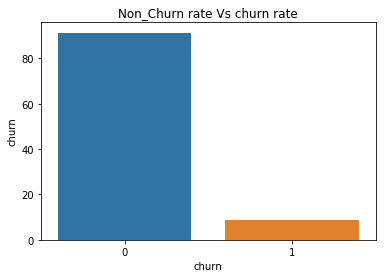

In [104]:
churn_percentage=(master_frame_HVC['churn'].value_counts()*100.0 /len(master_frame_HVC)),2
print(churn_percentage)

#churn_rate_graph = (master_frame_HVC['churn'].value_counts()*100.0 /len(master_frame_HVC)).plot(kind='bar',stacked = True,rot = 0,figsize = (8,6))                                                                                                                                                 
#churn_rate_graph.set_ylabel('% Customers',size = 14)
#churn_rate_graph.set_xlabel('Non_Churn Vs churn',size = 14)
#churn_rate_graph.set_title('churn Rate', size = 14)

sns.barplot(x="churn", y="churn", data=master_frame_HVC, estimator=lambda x: len(x) / len(master_frame_HVC) * 100)
plt.title("Non_Churn rate Vs churn rate")

           churn  high_value_customer
aon_years                            
0            672               4853.0
1            818               7616.0
2            504               4661.0
3            197               3044.0
4            110               1980.0
5             51               1251.0
6             78               2069.0
7             73               1826.0
8             53               1523.0
9             19                572.0
10            14                556.0
11             0                 28.0


Text(0.5, 1.0, 'Churn count based on age on network')

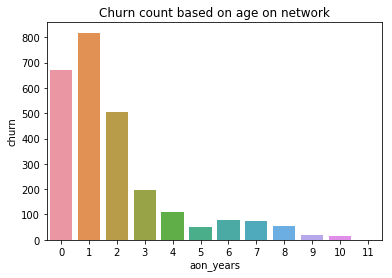

In [109]:
#Churn comparisions on other columns
#sns.boxplot(x=df.churn, y="aon_years", data=df)
#plt.title("Churn stats based on age on network")
aon_churn_hvc_counts=master_frame_HVC.pivot_table(index=['aon_years'],values=['high_value_customer','churn'], aggfunc='sum')
print(aon_churn_hvc_counts)

#plt.subplot(1,1, 1)
usa=sns.barplot(x=aon_churn_hvc_counts.index, y="churn", data=aon_churn_hvc_counts)
plt.title("Churn count based on age on network")


Text(0.5, 1.0, 'Churn stats based on arpu in August')

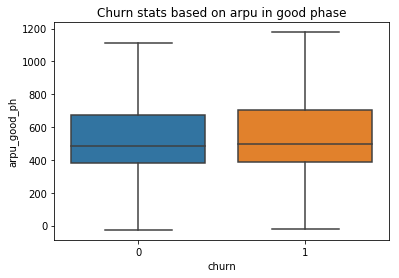

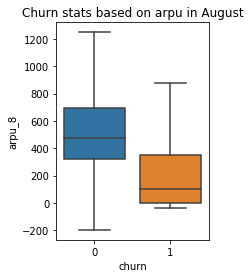

In [110]:
#Churn stats based on monthly ARPU
plt.figure(1)
plt.subplot(1,1, 1)
sns.boxplot(x=master_frame_HVC.churn, y="arpu_good_ph", data=master_frame_HVC, showfliers=False)
plt.title("Churn stats based on arpu in good phase")

plt.figure(2)
plt.subplot(1, 2, 2)
sns.boxplot(x=master_frame_HVC.churn, y="arpu_8", data=master_frame_HVC, showfliers=False)
plt.title("Churn stats based on arpu in August")



Text(0.5, 1.0, 'Churn stats based on total recharge in August')

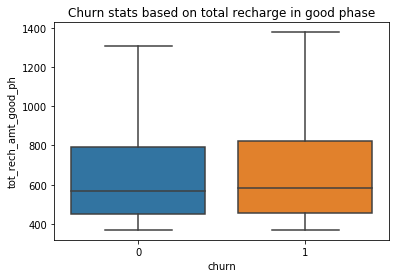

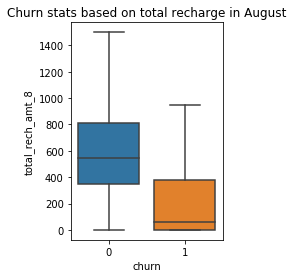

In [111]:
#Churn stats based on monthly Total recharge
plt.figure(1)
plt.subplot(1,1, 1)
sns.boxplot(x=master_frame_HVC.churn, y="tot_rech_amt_good_ph", data=master_frame_HVC, showfliers=False)
plt.title("Churn stats based on total recharge in good phase")

plt.figure(2)
plt.subplot(1, 2, 2)
sns.boxplot(x=master_frame_HVC.churn, y="total_rech_amt_8", data=master_frame_HVC, showfliers=False)
plt.title("Churn stats based on total recharge in August")


## Conclusions of univariate analysis

### 1. Churn rate is the highest for customers who are less thean 3 years with the operator.
### 2. The max revenue for churn customer is below the average revenue for non churn customer.
### 3. The max total recharge for churn customer is below the total recharge for non churn customer.

In [112]:
# Search Column name using string
#search = [col for col in df.columns if 'high' in col]
#search

### Scaling Data

In [115]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [116]:
# We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(master_frame_HVC, train_size = 0.7, test_size = 0.3, random_state = 100)

In [117]:
scaler=StandardScaler()
scaled_df=scaler.fit_transform(df_train)

C:\Users\Priyanka\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, int32, int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Priyanka\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype bool, int32, int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [118]:
# scaled_df = pd.DataFrame(scaled_df, columns=df.columns.tolist())

In [119]:
# scaled_df.head()

In [120]:


# plt.figure(figsize = (20,10))
# sns.heatmap(scaled_df.iloc[:,0:22].corr(),annot = True)

In [121]:
df_train.head()

,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon_years,sachet_2g_good_ph,...,vbc_3g_good_ph,std_ic_mou_good_ph,loc_ic_mou_good_ph,std_og_mou_good_ph,loc_og_mou_good_ph,vol_2g_mb_good_ph,vol_3g_mb_good_ph,churn,action_required,high_value_customer
mobile_number,,,,,,,,,,,,,,,,,,,,,
7000152939,23,1194,130,130,0,0,0,0,2,0.0,...,0.000,8.895,20.405,655.855,27.620,0.000,0.000,0,0,True
7001765325,7,210,50,50,1,0,0,0,2,0.0,...,1047.095,4.685,88.500,8.475,129.645,132.640,1218.350,0,1,True
7001859827,12,938,289,0,1,0,1,0,8,0.0,...,694.550,3.020,263.770,1.835,497.140,51.975,1028.615,0,1,True
7002292459,11,989,144,0,0,0,0,0,3,0.0,...,0.000,24.335,264.505,642.440,261.635,0.000,0.000,0,1,True
7001469476,10,578,144,130,0,0,0,0,1,0.0,...,0.000,16.140,47.290,911.645,18.110,0.000,0.000,0,1,True


In [122]:
df_train.describe()

,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon_years,sachet_2g_good_ph,...,total_og_mou_good_ph,vbc_3g_good_ph,std_ic_mou_good_ph,loc_ic_mou_good_ph,std_og_mou_good_ph,loc_og_mou_good_ph,vol_2g_mb_good_ph,vol_3g_mb_good_ph,churn,action_required
count,20985.000000,20985.000000,20985.000000,20985.000000,20985.000000,20985.000000,20985.000000,20985.000000,20985.000000,20985.000000,...,20985.000000,20985.000000,20985.000000,20985.000000,20985.000000,20985.000000,20985.000000,20985.000000,20985.000000,20985.000000
mean,10.261758,616.485108,163.369836,96.312700,0.116702,0.609864,0.173648,0.141720,2.944103,0.549392,...,699.799068,129.412309,52.812058,247.243500,405.688214,284.541077,78.484254,270.637971,0.084537,0.619347
std,9.506031,628.703912,176.648063,149.555059,0.363273,1.831635,0.585976,0.955164,2.708020,1.662446,...,606.592039,367.530461,135.618627,303.810418,569.260247,360.875436,253.819972,832.979487,0.278197,0.485559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,310.000000,67.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,313.665000,0.000000,4.860000,66.095000,9.785000,61.410000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,520.000000,130.000000,50.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,549.900000,0.000000,18.500000,156.500000,168.070000,175.485000,0.000000,0.000000,0.000000,1.000000
75%,13.000000,794.000000,198.000000,130.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,...,902.990000,27.705000,50.485000,315.985000,623.620000,373.855000,29.555000,106.580000,0.000000,1.000000
max,138.000000,45320.000000,4449.000000,4449.000000,5.000000,44.000000,16.000000,41.000000,11.000000,29.500000,...,7441.790000,6422.830000,5630.410000,5939.095000,7323.595000,6582.420000,7939.075000,36667.845000,1.000000,1.000000


###  Model Building

In [123]:
from sklearn.model_selection import train_test_split

X=df_train.drop(['churn'],axis=1)

y=df_train['churn']

y.head()

mobile_number
7000152939    0
7001765325    0
7001859827    0
7002292459    0
7001469476    0
Name: churn, dtype: int64

In [124]:
X_train , X_test , y_train , y_test = train_test_split(X,y,train_size=0.7, random_state=42,stratify=y)

C:\Users\Priyanka\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [125]:
X_train.head()

,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon_years,sachet_2g_good_ph,...,total_og_mou_good_ph,vbc_3g_good_ph,std_ic_mou_good_ph,loc_ic_mou_good_ph,std_og_mou_good_ph,loc_og_mou_good_ph,vol_2g_mb_good_ph,vol_3g_mb_good_ph,action_required,high_value_customer
mobile_number,,,,,,,,,,,,,,,,,,,,,
7001000711,9,497,152,30,0,2,0,2,3,0.5,...,123.220,0.000,0.000,964.605,0.000,122.480,0.00,339.165,1,True
7001792871,6,699,169,0,0,0,0,0,1,0.0,...,2305.460,0.000,19.510,73.750,2236.395,69.035,0.00,0.000,1,True
7000609303,5,560,150,130,0,0,0,0,4,0.0,...,529.545,0.000,30.490,81.815,451.390,76.420,0.00,0.000,0,True
7000709586,9,423,130,0,0,0,0,0,1,2.0,...,182.170,245.985,23.085,155.650,10.600,167.675,25.02,472.545,1,True
7002137049,10,700,130,130,0,0,0,1,2,0.0,...,606.545,0.000,63.680,194.240,301.385,305.150,0.00,0.000,1,True


In [126]:
X_train.shape

(14689, 88)

In [127]:
X_test.shape

(6296, 88)

In [128]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

C:\Users\Priyanka\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, int32, int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Priyanka\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype bool, int32, int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Priyanka\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, int32, int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Priyanka\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype bool, int32, int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [129]:
X_train = pd.DataFrame(X_train, columns=X.columns.tolist())
X_test = pd.DataFrame(X_test, columns=X.columns.tolist())

In [130]:
X_train.head()

,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon_years,sachet_2g_good_ph,...,total_og_mou_good_ph,vbc_3g_good_ph,std_ic_mou_good_ph,loc_ic_mou_good_ph,std_og_mou_good_ph,loc_og_mou_good_ph,vol_2g_mb_good_ph,vol_3g_mb_good_ph,action_required,high_value_customer
0,-0.139617,-0.217154,-0.065171,-0.431050,-0.323065,0.773847,-0.302102,2.00723,0.023603,-0.030275,...,-0.937646,-0.355396,-0.373060,2.336800,-0.707891,-0.441058,-0.322344,0.070151,0.791751,0.0
1,-0.449987,0.145518,0.029414,-0.625867,-0.323065,-0.338497,-0.302102,-0.14671,-0.714858,-0.329345,...,2.604397,-0.355396,-0.237634,-0.564181,3.180132,-0.586930,-0.322344,-0.314177,0.791751,0.0
2,-0.553444,-0.104043,-0.076299,0.218339,-0.323065,-0.338497,-0.302102,-0.14671,0.392834,-0.329345,...,-0.278130,-0.355396,-0.161418,-0.537918,0.076861,-0.566774,-0.322344,-0.314177,-1.263024,0.0
3,-0.139617,-0.350014,-0.187575,-0.625867,-0.323065,-0.338497,-0.302102,-0.14671,-0.714858,0.866933,...,-0.841962,0.310982,-0.212819,-0.297482,-0.689462,-0.317703,-0.218962,0.221292,0.791751,0.0
4,-0.036160,0.147313,-0.187575,0.218339,-0.323065,-0.338497,-0.302102,0.93026,-0.345627,-0.329345,...,-0.153150,-0.355396,0.068965,-0.171817,-0.183926,0.057521,-0.322344,-0.314177,0.791751,0.0


In [131]:
X_test.head()

,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon_years,sachet_2g_good_ph,...,total_og_mou_good_ph,vbc_3g_good_ph,std_ic_mou_good_ph,loc_ic_mou_good_ph,std_og_mou_good_ph,loc_og_mou_good_ph,vol_2g_mb_good_ph,vol_3g_mb_good_ph,action_required,high_value_customer
0,-0.225595,-0.003982,-0.109731,0.345053,-0.317129,-0.321217,-0.283273,-0.152349,1.860810,-0.333224,...,-0.325015,-0.344428,0.093682,0.364766,-0.122563,-0.324507,1.691835,-0.362625,-1.305553,0.0
1,-0.554608,-0.479024,-0.050635,-0.621460,2.523044,-0.321217,-0.283273,-0.152349,-0.355686,-0.333224,...,-0.825873,-0.344428,-0.417142,1.110666,-0.721204,-0.345505,0.441982,-0.021129,0.765959,0.0
2,-0.444937,0.297138,0.528505,0.244074,-0.317129,-0.321217,1.397678,-0.152349,0.013730,-0.333224,...,-0.816709,-0.342957,-0.245927,-0.078395,-0.477244,-0.584906,-0.281777,0.480170,0.765959,0.0
3,-0.335266,-0.371296,-0.192465,-0.693588,-0.317129,0.727193,-0.283273,-0.152349,-1.094518,-0.333224,...,-0.614090,-0.344428,-0.278055,0.093346,-0.482036,-0.246730,-0.284837,-0.362625,0.765959,0.0
4,-0.554608,-0.488110,-0.600227,-0.253608,-0.317129,-0.321217,-0.283273,-0.152349,1.121978,-0.333224,...,-0.652976,-0.344428,0.485691,-0.357079,-0.590667,-0.126324,-0.284837,-0.362625,0.765959,0.0


In [132]:

# logreg = LogisticRegression()
# from sklearn.feature_selection import RFE
# rfe = RFE(logreg, 50)             # running RFE with 50 variables as output
# rfe = rfe.fit(X,y)
# print(rfe.support_)           # Printing the boolean results
# print(rfe.ranking_) 

In [133]:
# rfe_df=pd.DataFrame({'features':X.columns.tolist(),'flag':rfe.support_,'rank':rfe.ranking_})

In [134]:
# rfe_df.sort_values('rank').head(60)

In [135]:
?PCA

In [136]:
from sklearn.decomposition import IncrementalPCA
pca = IncrementalPCA(n_components=59,)

In [137]:
?IncrementalPCA

In [138]:
X_train_pca=pca.fit_transform(X_train)

In [139]:
X_train_pca.shape

(14689, 59)

In [140]:
pca.components_

array([[ 0.08634324,  0.22872481,  0.12627848, ...,  0.03011112,
        -0.0315352 , -0.        ],
       [ 0.15000917,  0.07837646, -0.07260078, ..., -0.0752838 ,
        -0.04076576,  0.        ],
       [-0.06246018,  0.18120253,  0.22530331, ...,  0.26854728,
         0.00059698, -0.        ],
       ...,
       [-0.00828581, -0.04219965, -0.03447592, ...,  0.01207479,
        -0.00084877, -0.        ],
       [ 0.17755691,  0.08895955,  0.06621601, ...,  0.01004937,
        -0.06171246, -0.        ],
       [-0.07075254,  0.09798993,  0.59145723, ...,  0.04378815,
        -0.0214091 , -0.        ]])

In [141]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df

,PC1,PC2,Feature
0,0.086343,0.150009,total_rech_num_8
1,0.228725,0.078376,total_rech_amt_8
2,0.126278,-0.072601,max_rech_amt_8
3,0.104817,-0.060428,last_day_rch_amt_8
4,0.010100,-0.064374,monthly_2g_8
5,-0.004220,0.016280,sachet_2g_8
6,0.048154,-0.076847,monthly_3g_8
7,0.003349,-0.000568,sachet_3g_8
8,0.037505,-0.111760,aon_years
9,-0.013804,0.008827,sachet_2g_good_ph


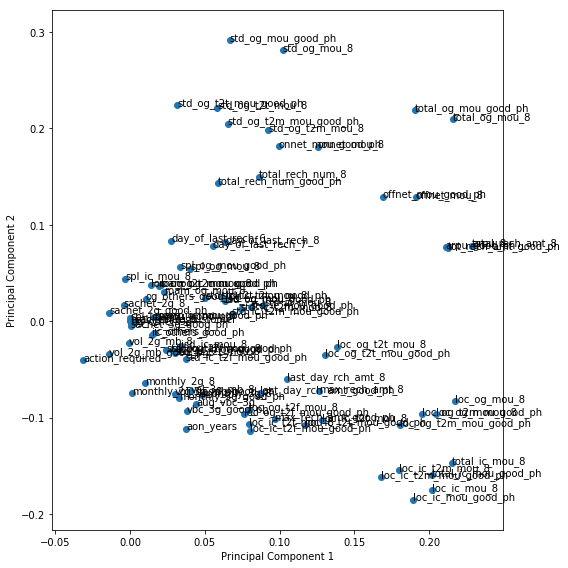

In [142]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [143]:
# %matplotlib inline
# fig = plt.figure(figsize = (8,8))
# plt.scatter(scaled_df[:,0], scaled_df[:,1], c = y_train.map({0:'green',1:'red'}))
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.tight_layout()
# plt.show()

In [144]:
pca.explained_variance_ratio_

array([0.10474203, 0.09262455, 0.06121514, 0.05018776, 0.04245236,
       0.03895429, 0.0299283 , 0.02911688, 0.02750884, 0.02729589,
       0.02597548, 0.02500141, 0.02325895, 0.02211705, 0.02111396,
       0.01965872, 0.01853053, 0.01736334, 0.01606565, 0.01588949,
       0.01506606, 0.01485142, 0.01330797, 0.01303146, 0.01243915,
       0.01083815, 0.01020527, 0.00998089, 0.0098663 , 0.00930442,
       0.00928104, 0.00862718, 0.00834116, 0.00798318, 0.00768374,
       0.00751971, 0.00724239, 0.00701937, 0.00676021, 0.00635602,
       0.00610147, 0.00563652, 0.00552467, 0.00535557, 0.00512071,
       0.00497261, 0.00461547, 0.00419674, 0.00394136, 0.00382493,
       0.00375573, 0.00353474, 0.00336936, 0.0029349 , 0.00290509,
       0.00274292, 0.00258941, 0.00241914, 0.00225334])

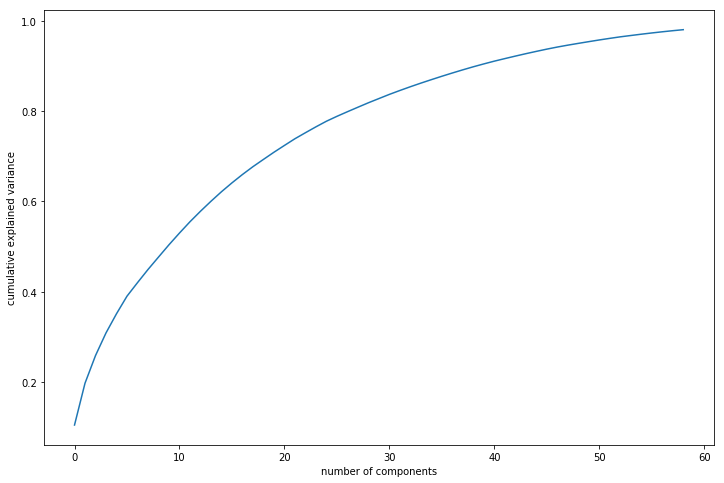

In [145]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [146]:
X_train.head()

,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon_years,sachet_2g_good_ph,...,total_og_mou_good_ph,vbc_3g_good_ph,std_ic_mou_good_ph,loc_ic_mou_good_ph,std_og_mou_good_ph,loc_og_mou_good_ph,vol_2g_mb_good_ph,vol_3g_mb_good_ph,action_required,high_value_customer
0,-0.139617,-0.217154,-0.065171,-0.431050,-0.323065,0.773847,-0.302102,2.00723,0.023603,-0.030275,...,-0.937646,-0.355396,-0.373060,2.336800,-0.707891,-0.441058,-0.322344,0.070151,0.791751,0.0
1,-0.449987,0.145518,0.029414,-0.625867,-0.323065,-0.338497,-0.302102,-0.14671,-0.714858,-0.329345,...,2.604397,-0.355396,-0.237634,-0.564181,3.180132,-0.586930,-0.322344,-0.314177,0.791751,0.0
2,-0.553444,-0.104043,-0.076299,0.218339,-0.323065,-0.338497,-0.302102,-0.14671,0.392834,-0.329345,...,-0.278130,-0.355396,-0.161418,-0.537918,0.076861,-0.566774,-0.322344,-0.314177,-1.263024,0.0
3,-0.139617,-0.350014,-0.187575,-0.625867,-0.323065,-0.338497,-0.302102,-0.14671,-0.714858,0.866933,...,-0.841962,0.310982,-0.212819,-0.297482,-0.689462,-0.317703,-0.218962,0.221292,0.791751,0.0
4,-0.036160,0.147313,-0.187575,0.218339,-0.323065,-0.338497,-0.302102,0.93026,-0.345627,-0.329345,...,-0.153150,-0.355396,0.068965,-0.171817,-0.183926,0.057521,-0.322344,-0.314177,0.791751,0.0


In [147]:
corrmat = np.corrcoef(X_train_pca.transpose())

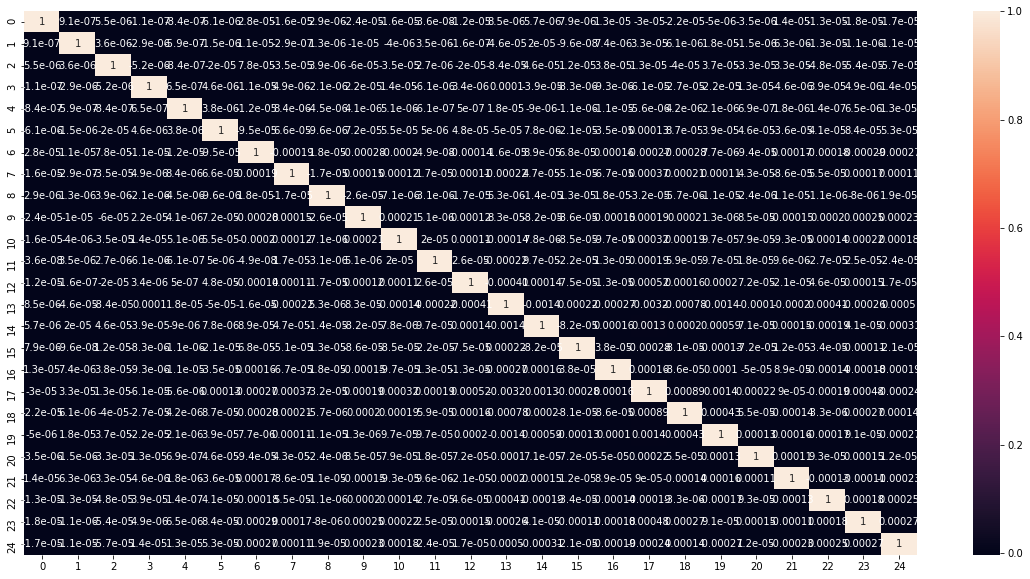

In [148]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat[0:25,0:25],annot = True)


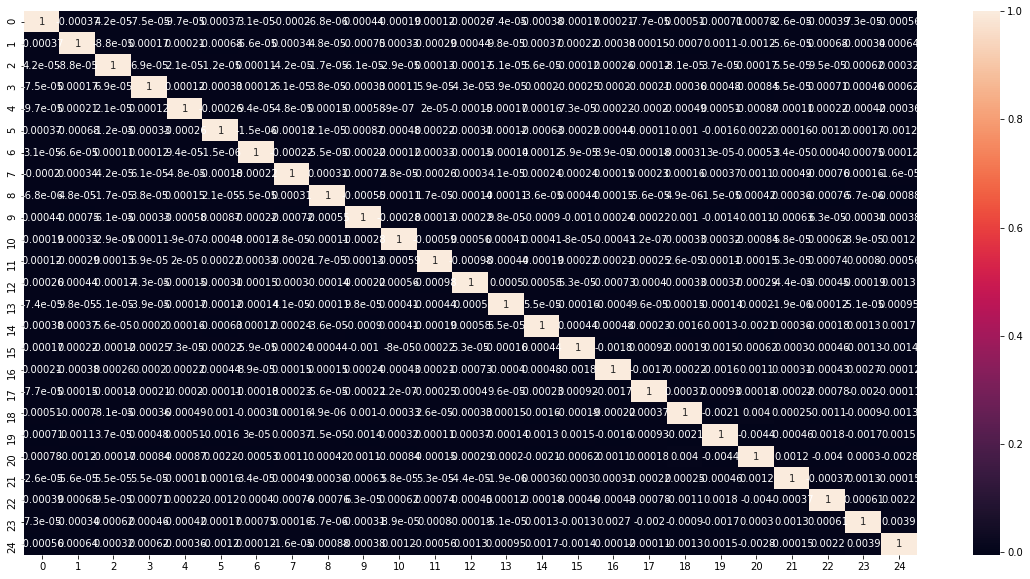

In [149]:
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat[25:50,25:50],annot = True)

In [150]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.004611863282599609 , min corr:  -0.007906473800291131


In [151]:
#Applying selected components to the test data - 16 components
X_test_pca = pca.transform(X_test)
X_test_pca.shape

(6296, 59)

In [152]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

learner_pca = LogisticRegression(class_weight='balanced')
model_pca = learner_pca.fit(X_train_pca,y_train)

C:\Users\Priyanka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [153]:
#Making prediction on the train data
y_train_pred = model_pca.predict_proba(X_train_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_train, y_train_pred))

'0.91'

In [154]:
#Making prediction on the test data
y_pred = model_pca.predict_proba(X_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, y_pred))

'0.89'

In [155]:
from sklearn.metrics import precision_score,recall_score,accuracy_score,confusion_matrix

In [156]:
y_pred=pd.Series(y_pred)
y_train_pred=pd.Series(y_train_pred)

In [157]:
y_pred_bool= y_pred.apply(lambda x: 1 if x>=0.5 else 0)
y_train_pred_bool= y_train_pred.apply(lambda x: 1 if x>=0.5 else 0)

In [158]:
confusion_matrix(y_test,y_pred_bool)

array([[4802,  962],
       [  94,  438]], dtype=int64)

In [159]:
confusion_matrix(y_train,y_train_pred_bool)

array([[11256,  2191],
       [  180,  1062]], dtype=int64)

In [160]:
import  sklearn.metrics

In [161]:
metrics.precision_score(y_test,y_pred_bool)

0.31285714285714283

In [162]:
recall_score(y_test,y_pred_bool)

0.8233082706766918

In [163]:
accuracy_score(y_test,y_pred_bool)

0.832274459974587

In [164]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [165]:
fpr, tpr, thresholds = metrics.roc_curve( y_train, y_train_pred, drop_intermediate = False )

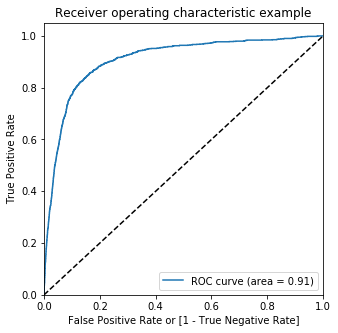

In [166]:
draw_roc(y_train, y_train_pred)

In [198]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

confusion=confusion_matrix(y_train,y_train_pred_bool)

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train,y_train_pred_bool)
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.838587  0.855072  0.837064
0.1   0.1  0.838587  0.855072  0.837064
0.2   0.2  0.838587  0.855072  0.837064
0.3   0.3  0.838587  0.855072  0.837064
0.4   0.4  0.838587  0.855072  0.837064
0.5   0.5  0.838587  0.855072  0.837064
0.6   0.6  0.838587  0.855072  0.837064
0.7   0.7  0.838587  0.855072  0.837064
0.8   0.8  0.838587  0.855072  0.837064
0.9   0.9  0.838587  0.855072  0.837064


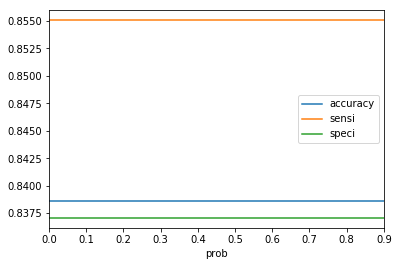

In [168]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [169]:
pca_again = PCA(0.90)

In [170]:
df_train_pca2 = pca_again.fit_transform(X_train)
df_train_pca2.shape

(14689, 40)

In [171]:
learner_pca2 = LogisticRegression()
model_pca2 = learner_pca2.fit(df_train_pca2,y_train)

C:\Users\Priyanka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [172]:
df_test_pca2 = pca_again.transform(X_test)
df_test_pca2.shape

(6296, 40)

In [173]:
#Making prediction on the test data
pred_probs_test2 = model_pca2.predict_proba(df_test_pca2)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test2))

'0.88'

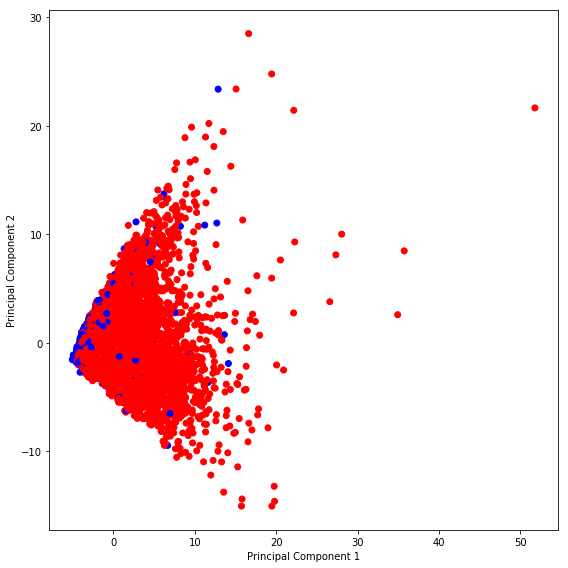

In [174]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(df_train_pca2[:,0], df_train_pca2[:,1], c = y_train.map({0:'red',1:'blue'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

In [175]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [176]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [177]:
pca.components_

array([[ 8.63540126e-02,  2.28719774e-01,  1.26266599e-01, ...,
         3.01175253e-02, -3.15368141e-02, -0.00000000e+00],
       [ 1.50004291e-01,  7.83670888e-02, -7.25991450e-02, ...,
        -7.52804621e-02, -4.07645488e-02, -0.00000000e+00],
       [-6.24187395e-02,  1.81143501e-01,  2.25255906e-01, ...,
         2.68530430e-01,  5.91969942e-04, -0.00000000e+00],
       ...,
       [-9.80413069e-09,  9.72340870e-08, -3.50858507e-08, ...,
        -3.10610578e-09,  1.06396643e-07, -0.00000000e+00],
       [ 6.81313294e-09, -5.75219152e-08,  4.68652953e-08, ...,
        -7.07197622e-10,  1.91375340e-08,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [178]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

,PC1,PC2,Feature
0,0.086354,0.150004,total_rech_num_8
1,0.228720,0.078367,total_rech_amt_8
2,0.126267,-0.072599,max_rech_amt_8
3,0.104824,-0.060427,last_day_rch_amt_8
4,0.010101,-0.064373,monthly_2g_8


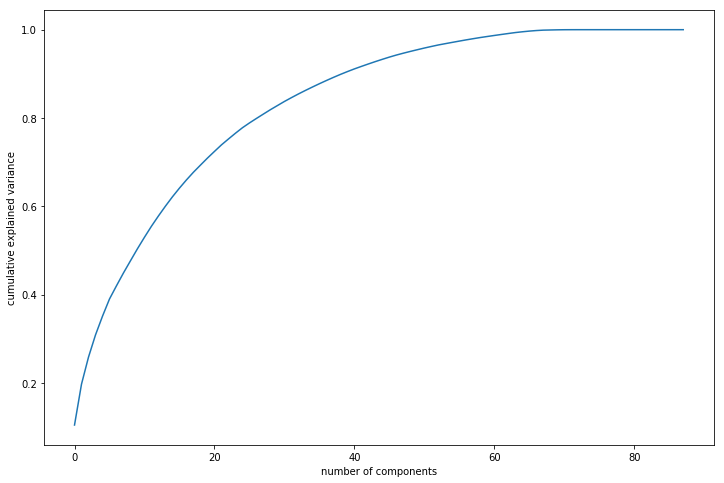

In [179]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [180]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=59)

In [181]:
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(14689, 59)

In [182]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

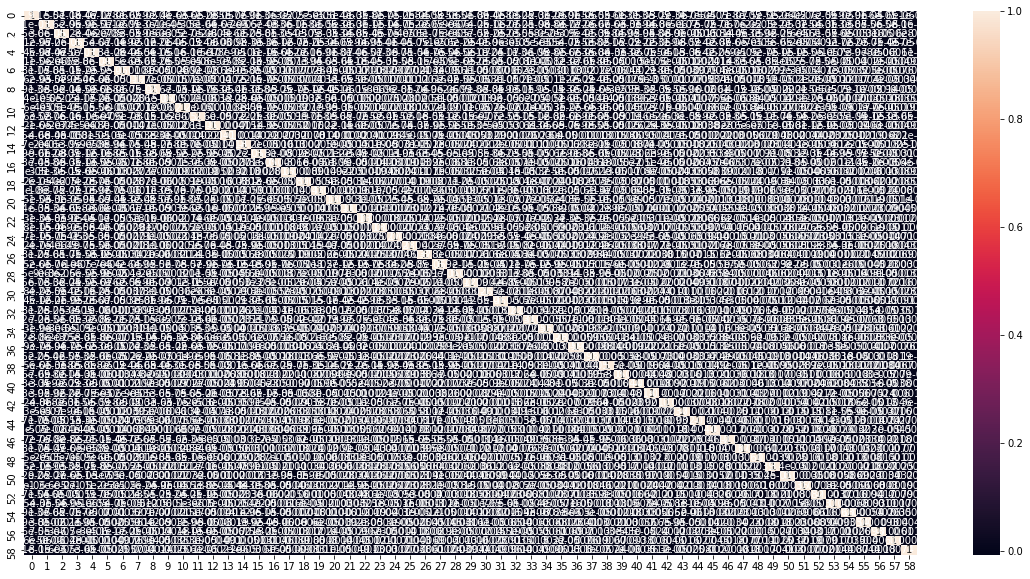

In [183]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [184]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.004611863282599609 , min corr:  -0.007906473800291131


In [185]:
#Applying selected components to the test data - 16 components
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(6296, 59)

In [186]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_train)

C:\Users\Priyanka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [187]:
#Making prediction on the test data
pred_probs_train = model_pca.predict_proba(df_train_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_train, pred_probs_train))

'0.91'

In [188]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.89'

In [189]:
y_out_put_df=pd.DataFrame({"y_test":y_test, "pred_probs_test":pred_probs_test})

In [190]:
X_out_put_df=pd.DataFrame({"y_train":y_train, "pred_probs_train":pred_probs_train})

In [191]:
y_out_put_df['pred_probs_test']=y_out_put_df['pred_probs_test'].apply(lambda x: 1 if x>=0.3 else 0)

In [192]:
X_out_put_df['pred_probs_train']=X_out_put_df['pred_probs_train'].apply(lambda x: 1 if x>=0.3 else 0)

In [193]:
y_out_put_df.head()

,y_test,pred_probs_test
mobile_number,,
7001408702,0,0
7002355810,0,0
7001332856,0,0
7001353966,0,0
7002292306,0,0


In [194]:
confusion_matrix(y_out_put_df.y_test,y_out_put_df.pred_probs_test)

array([[5478,  286],
       [ 198,  334]], dtype=int64)

In [195]:
X_out_put_df.head()

,y_train,pred_probs_train
mobile_number,,
7001000711,0,0
7001792871,0,0
7000609303,0,0
7000709586,0,0
7002137049,0,0


In [196]:
confusion_matrix(X_out_put_df.y_train,X_out_put_df.pred_probs_train)

array([[12864,   583],
       [  508,   734]], dtype=int64)